In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import gmaps
import seaborn as sns
low_memory=False
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50110)
pd.set_option('display.width', 1000111)
pd.set_option('display.max_colwidth', 1000111)

# FordGo Bikes
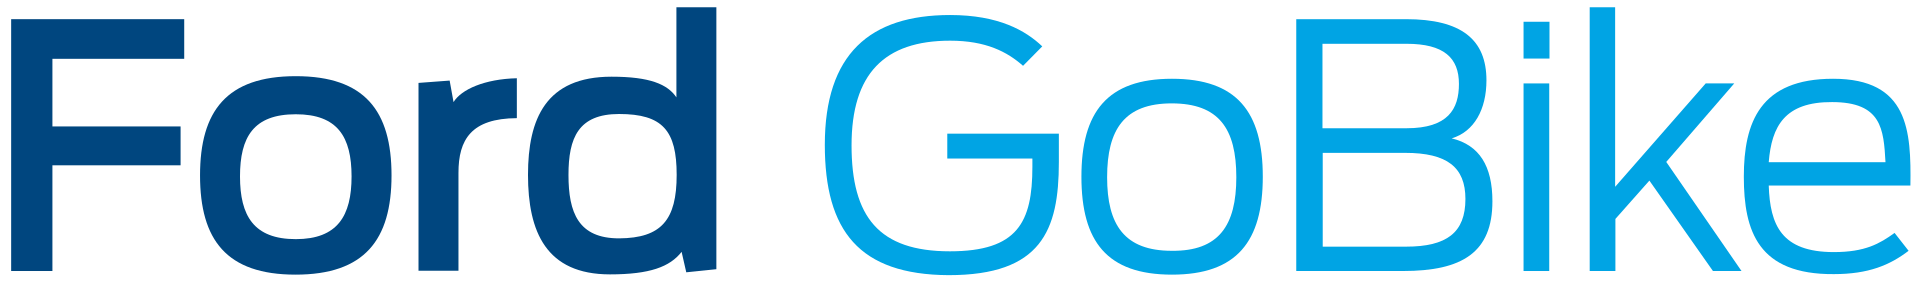
### Prediction of number of bike rides (based on weather)



# 1. Introduction

Ford Gobike is a regional bike sharing public service in the Bay Area, CA, USA. In 2017, the service brought Ford Motor Company on-board to expand the scale of their operations. Currently, Ford Gobike serves the Bay Area, East Bay and San Jose. <i>(Etherington, Darrell (June 27, 2017). "Ford GoBike launches in the Bay Area starting tomorrow". TechCrunch. Retrieved July 23, 2017.)</i>

They have released their bike share data in the CSV format on their website. We will use their publicly available dataset for this project. This project aims to study the effects of weather on the quality and number of bike rides that took place in the Bay Area in the year of 2018.

Given our datasets, we want to describe them in detail to understand the patterns of weather and biking. Analyzing them will give us insights on how the data are structured and whether there have been any outliers due to events in the area. For instance, an unusually high number of bike rides might be observed due to a concert or a public event in that area. 

Contrastingly, the recent California wildfires would have reduced the number of bikers.

Furthermore, The ability to predict the number of rides due to weather can allow the businesses that oversee demand and planning systems to manage them in a more efficient and cost-effective manner.

While doing the above, we will also attempt to understand the characteristics of our user base. We have a limited number of variables describing them, but we will equate the social and economic aspects of our user base to understand their biking patterns.

## 2. Data Description- Biking Dataset

In [3]:
filepath = "C:/Users/pujar/Dropbox/Semester 2/Python-BUDT758X/Pawject/data/"
desc = pd.read_csv(filepath+"desc_bike.csv",encoding='utf-8')
desc

Column                                       Description
0              duration_sec                       Duration of trip in seconds
1                start_time                          Timestamp; journey start
2                  end_time                            Timestamp; journey end
3          start_station_id                                      ID of source
4        start_station_name                                    Name of source
5    start_station_latitude                                Latitude of source
6   start_station_longitude                               Longitude of source
7            end_station_id                                 ID of destination
8          end_station_name                               Name of destination
9      end_station_latitude                           Latitude of destination
10    end_station_longitude                          Longitude of destination
11                  bike_id                                     ID of vehicle
12                user_type                       One-time user or subscriber
13        member_birth_year                                         self expl
14            member_gender                                         self expl
15  bike_share_for_all_trip  Subscription to low income payment plan (Yes/No)

## 3. Data Description- Weather Dataset

In [4]:
desc = pd.read_csv(filepath+"desc_weather.csv",encoding='utf-8')
desc

Column                                                          Description
0           Date                                                                 Date
1        Maximum                                                  Maximum temperature
2        Minimum                                                  Minimum temperature
3        Average                                                  Average temperature
4      Departure           Difference between that day's temperature and 30-year mean
5            HDD                                                       Heating factor
6            CDD                                                       Cooling factor
7  Precipitation                                                       Rain in inches
8       New Snow  It does not snow in San Francisco; hence this can be ignored safely
9     Snow depth  It does not snow in San Francisco; hence this can be ignored safely

## 4. Datasets loaded, cleaned, and transformed

### 4.1 Separate start_time and end_time to get dates and times

In [6]:
wdf = pd.read_csv(filepath+"SF_Weather_2018.csv",encoding='utf-8')
bdf = pd.read_csv(filepath+'all.csv', encoding='utf-8', sep=',')

#Creating more columns to process the timestamp to date and time separately
bdf.insert(2, 'start_date', 0)
bdf.insert(3, 'end_date', 0)
bdf.insert(4, 'start_timing', 0)
bdf.insert(5, 'end_timing', 0)

# Converting timestamp to string type for easy REGEX-ing (if that's a term!)
bdf['start_time'] = bdf['start_time'].astype(str)
bdf['end_time']   = bdf['end_time'].astype(str)
    
bdf['start_date'] = bdf['start_time'].str.extract('(\d\d\d\d-\d\d-\d\d)')
bdf['start_timing'] = bdf['start_time'].str.extract('(\d\d:\d\d:\d\d.\d\d\d\d)')
    
bdf['end_date'] = bdf['end_time'].str.extract('(\d\d\d\d-\d\d-\d\d)')
bdf['end_timing'] = bdf['end_time'].str.extract('(\d\d:\d\d:\d\d.\d\d\d\d)')

### 4.2 Remove additional headers that Pandas duplicated

In [7]:
# NOTE- Pandas seems to re-add CSV headers every 100,000 or so rows. 
# Therefore, we have removed the rows with repeating headers.
bdf = bdf[bdf['start_time'] != 'start_time']

### 4.3 Merge the two datasets to equate weather and biking data

In [8]:
# Merge the two dataframes to get weather data corresponding to bike rides
wdf['Date'] = pd.to_datetime(wdf['Date']).dt.strftime('%Y-%m-%d')
df = pd.merge(bdf, wdf, left_on='start_date', right_on='Date')


### 4.4 Remove columns that are not relevant

In [9]:
del wdf['New Snow']
del wdf['Snow Depth']
wdf.head()

Date  Maximum  Minimum  Average  Departure  HDD  CDD  Precipitation
0  2018-01-01       61       48     54.5        3.9   10    0           0.00
1  2018-01-02       61       52     56.5        5.9    8    0           0.00
2  2018-01-03       58       53     55.5        4.9    9    0           0.09
3  2018-01-04       63       53     58.0        7.4    7    0           0.06
4  2018-01-05       61       52     56.5        5.9    8    0           0.26

## 5. Breakdown of Rides per month

#### According to the below bar chart, it is evident that summer months tend to have higher biking rates. A sharp decline in biking is observed from Oct-Nov (shaded in graph). Further research shows that the Californian wildfires reduced air quality manifold. Due to high levels of pollution, San Franciscans preferred to avoid open air exertion.
Source: https://www.popsci.com/fires-california-air-quality-cigarettes

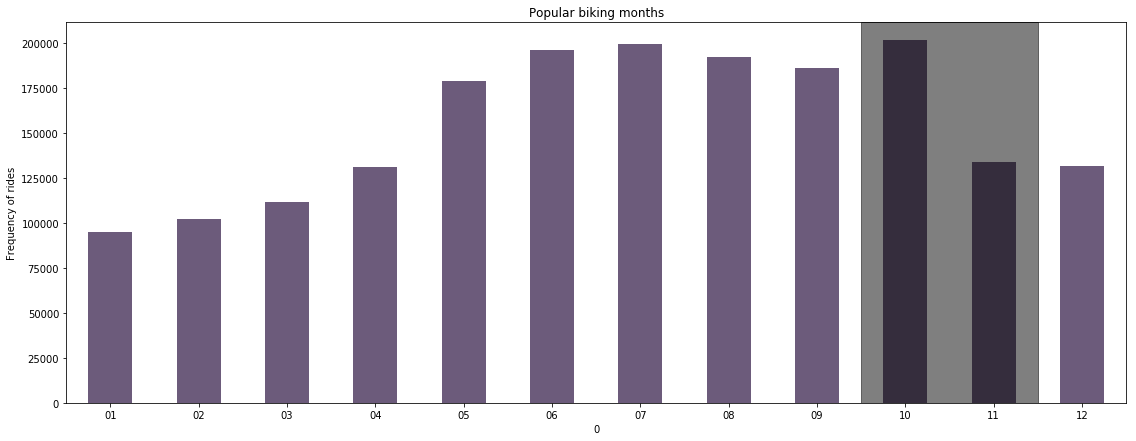

In [10]:
from itertools import cycle, islice
# Using different colors to represent data
mycolors= "#6C5B7B"

# Extract the month using REGEX
ser = df['start_date'].str.extract("(-\d{1,2})")
ser[0] = ser[0].str.replace('-','')
ser = ser[0].groupby(ser[0]).count()

# Plot
plt.figure(figsize=(19,7), facecolor='white')
plt.title("Popular biking months")
plt.ylabel('Frequency of rides')
plt.xlabel('Month')
ser.plot.bar(x='lab', y='val', rot=0, color=mycolors)
plt.axvspan(8.5, 10.5, color='black', alpha=0.5)
plt.show()

## 6. Daily usage of bike rides & weather patterns

#### San Francisco's weather is strongly influenced by the cool currents of the Pacific Ocean on the west side of the city. This moderates temperature swings and produces a remarkably mild year-round climate with little seasonal temperature variation. 

#### As we can see from the plot, the temperature in SF is between 40 degrees to 80 degrees the whole year which is quite comfortable for riding bike outdoors

#### Also, cooler months have fewer rides than warmer months.

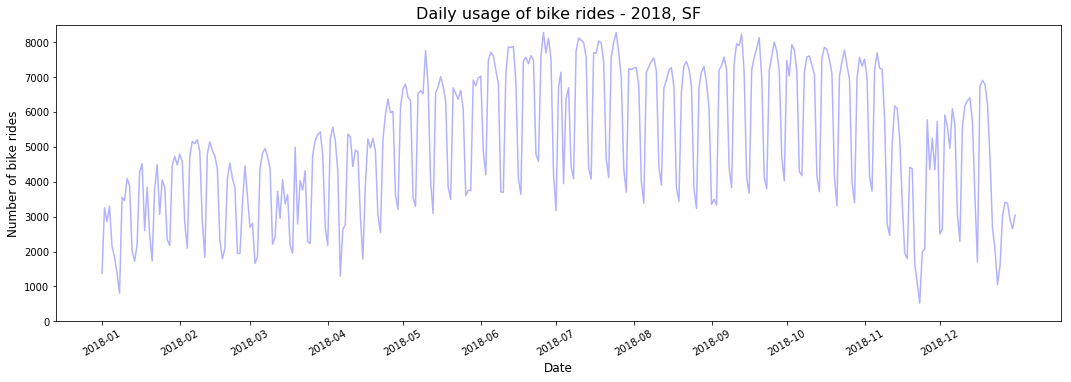

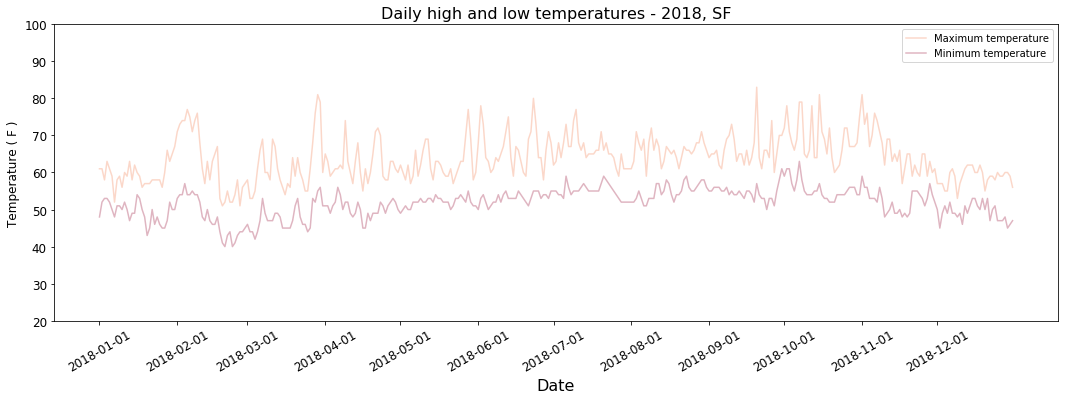

In [11]:
#Create a new dataset that has count the date as the number of rides
df1=df.Date.value_counts()
df1=df1.to_frame()
df1=df1.rename(columns={'Date':'Number of Bike rides'})
df1.index.names = ['Date']
#sort index as date
df1=df1.sort_index()

from datetime import datetime
import matplotlib.dates as mdate
import matplotlib as mpl
import datetime as dt
import matplotlib.pyplot as py

#Generate two plot--weather pattern and daily usage of bike rides
fig = plt.figure(figsize=(18,12),facecolor='white')
ax1 = fig.add_subplot(2,1,1) # Add the first plot on the top 
df1.index =  pd.to_datetime(df1.index, format='%Y-%m-%d')#Transform the data type and used for changing the x axis later
plt.title('Daily usage of bike rides - 2018, SF',fontsize=16)
plt.xlabel('Date',fontsize=12)
#Change the x axis as months
ax1.xaxis.set_major_formatter(mdate.DateFormatter('%b %Y'))
dateFmt = mpl.dates.DateFormatter('%Y-%m')
ax1.xaxis.set_major_formatter(dateFmt)
#Give the range of x axis from 2018-1-1 to 2018-12-31 and set the frequncy of x label as months
plt.xticks(pd.date_range('2018-01','2018-12',freq='MS'),rotation=30)
plt.ylabel("Number of bike rides",fontsize=12)
plt.ylim([0,8500])
plt.plot(df1.index,df1['Number of Bike rides'],label='Number of bike rides',c='blue',alpha=0.3)

#Add the second plot on the bottom
fig = plt.figure(figsize=(18,12), facecolor='white')
ax = fig.add_subplot(2,1,2)
wdf['Date'] =  pd.to_datetime(wdf['Date'], format='%Y-%m-%d')
plt.plot(wdf['Date'],wdf['Maximum'],label='Maximum temperature',c='#F8B195',alpha=0.5)  
plt.plot(wdf['Date'],wdf['Minimum'],label='Minimum temperature',c='#C06C84',alpha=0.5)
plt.title('Daily high and low temperatures - 2018, SF',fontsize=16)

plt.xlabel('Date',fontsize=16)
#Change the x axis again to months
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdate.MonthLocator())
#Give the range of x axis from 2018-1-1 to 2018-12-31 and set the frequncy of x label as months
plt.xticks(pd.date_range('2018-01-01','2018-12-31',freq="MS"),rotation=30)
plt.ylabel("Temperature ( F )",fontsize=12)
plt.ylim([20,100])

plt.tick_params(axis='both',which='major',labelsize=12)
plt.legend()
plt.show()

## 7. Most popular biking hours based on Start Time

### This resembles a bimodal distribution. <br>Biking peaks at the start of office hours (from 6-10 AM) and does so again after the end of office hours (4-7 PM).

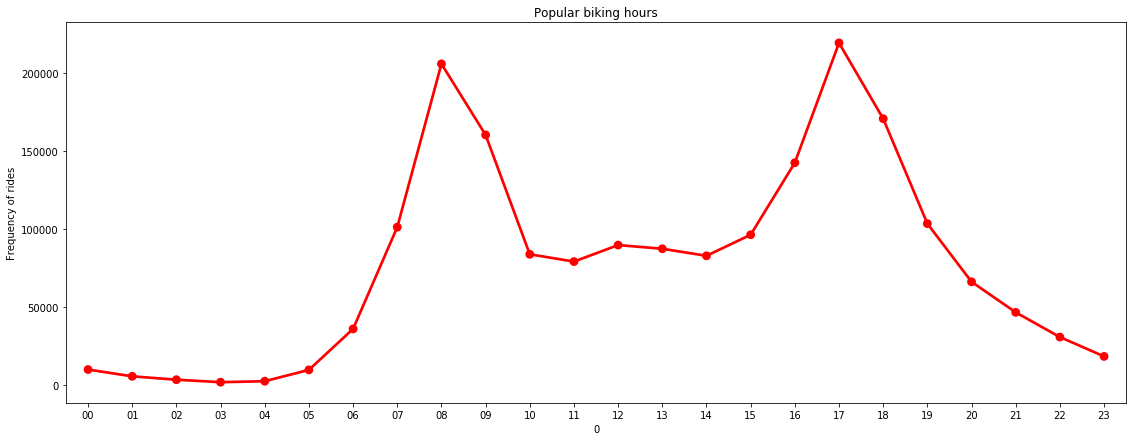

In [12]:
# Extract the hour of the day using REGEX
ser = df['start_timing'].astype('str')
ser = ser.str.extract("(\d{1,2})")
ser = ser[0].groupby(ser[0]).count()

# Plot 
plt.figure(figsize=(19,7), facecolor='white')
plt.title("Popular biking hours")
plt.ylabel('Frequency of rides')
plt.xlabel('Hour of the day')
sns.pointplot(x=ser.index, y=ser.values,color='red');
plt.show()
 

## 8. Most popular locations of trips

#### 8.1 Source of trips
##### The below stations are either transport (train or ferry) stations or business district areas proximal to offices.

In [13]:
print(df['start_station_name'].value_counts().sort_values(ascending=False).head(10))

San Francisco Ferry Building (Harry Bridges Plaza)           38357
San Francisco Caltrain Station 2  (Townsend St at 4th St)    37530
San Francisco Caltrain (Townsend St at 4th St)               34976
Market St at 10th St                                         34830
Berry St at 4th St                                           33625
The Embarcadero at Sansome St                                33311
Montgomery St BART Station (Market St at 2nd St)             32047
Powell St BART Station (Market St at 4th St)                 31578
Steuart St at Market St                                      28289
Howard St at Beale St                                        26444
Name: start_station_name, dtype: int64


#### 8.2 Source of trips
##### Google Maps Visualization

##### According to the below map, most trips start around popular transport hubs and offices

In [12]:
import gmaps
import gmaps.datasets
key = " "
# Use google maps api
gmaps.configure(api_key=key) # Fill in with your API key
#set up locations
start_locations = df[['start_station_latitude', 'start_station_longitude']]
start_df=start_locations.sample(400000)
start_df1= start_df.groupby(by=['start_station_latitude','start_station_longitude'])
start_df2= pd.DataFrame(start_df1.size())
start_df2.rename(columns={0: 'Numbers'}, inplace=True)
start_df2=start_df2.reset_index()
start_df2['Numbers']=start_df2['Numbers'].astype('float')
start_df2['start_station_latitude']=start_df2['start_station_latitude'].astype('float')
start_df2['start_station_longitude']=start_df2['start_station_longitude'].astype('float')
#set up map
start_fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(
    start_df2[['start_station_latitude','start_station_longitude']], weights=start_df2['Numbers'],
    max_intensity=100, point_radius=5.0
)
start_fig.add_layer(heatmap_layer)
start_fig

Figure(layout=FigureLayout(height='420px'))

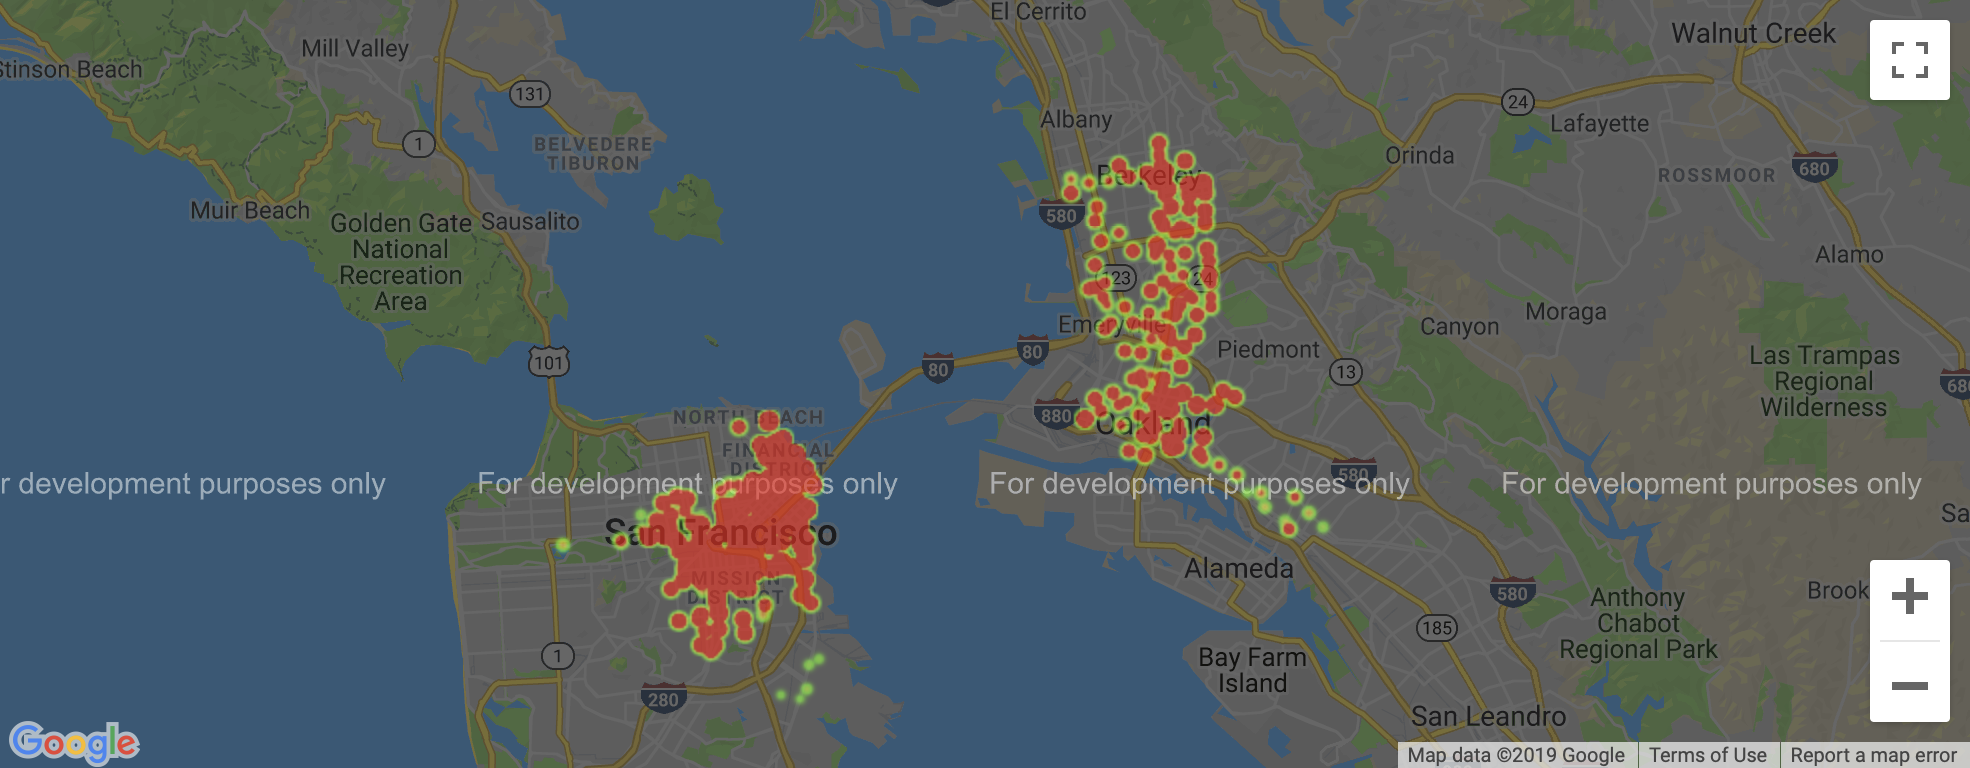

#### 8.3 Destination of trips
##### The below stations are either transport (train or ferry) stations or business district areas proximal to offices.

In [13]:
print(df['end_station_name'].value_counts().sort_values(ascending=False).head(10))

San Francisco Caltrain Station 2  (Townsend St at 4th St)    49872
San Francisco Ferry Building (Harry Bridges Plaza)           43997
San Francisco Caltrain (Townsend St at 4th St)               42814
The Embarcadero at Sansome St                                39127
Montgomery St BART Station (Market St at 2nd St)             35846
Market St at 10th St                                         34286
Powell St BART Station (Market St at 4th St)                 33017
Berry St at 4th St                                           32688
Steuart St at Market St                                      28517
Powell St BART Station (Market St at 5th St)                 25948
Name: end_station_name, dtype: int64


#### 8.4 Destination of trips
##### Google Maps Visualization

In [14]:
#set up locations
end_locations = df[['end_station_latitude','end_station_longitude']]
end_df=end_locations.sample(400000)
end_df1= end_df.groupby(by=['end_station_latitude','end_station_longitude'])
end_df2= pd.DataFrame(end_df1.size())
end_df2.rename(columns={0: 'Numbers'}, inplace=True)
end_df2=end_df2.reset_index()
end_df2['Numbers']=end_df2['Numbers'].astype('float')
end_df2['end_station_latitude']=end_df2['end_station_latitude'].astype('float')
end_df2['end_station_longitude']=end_df2['end_station_longitude'].astype('float')
#set up map
end_fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(
    end_df2[['end_station_latitude','end_station_longitude']], weights=end_df2['Numbers'],
    max_intensity=100, point_radius=5.0
)
end_fig.add_layer(heatmap_layer)
end_fig

Figure(layout=FigureLayout(height='420px'))

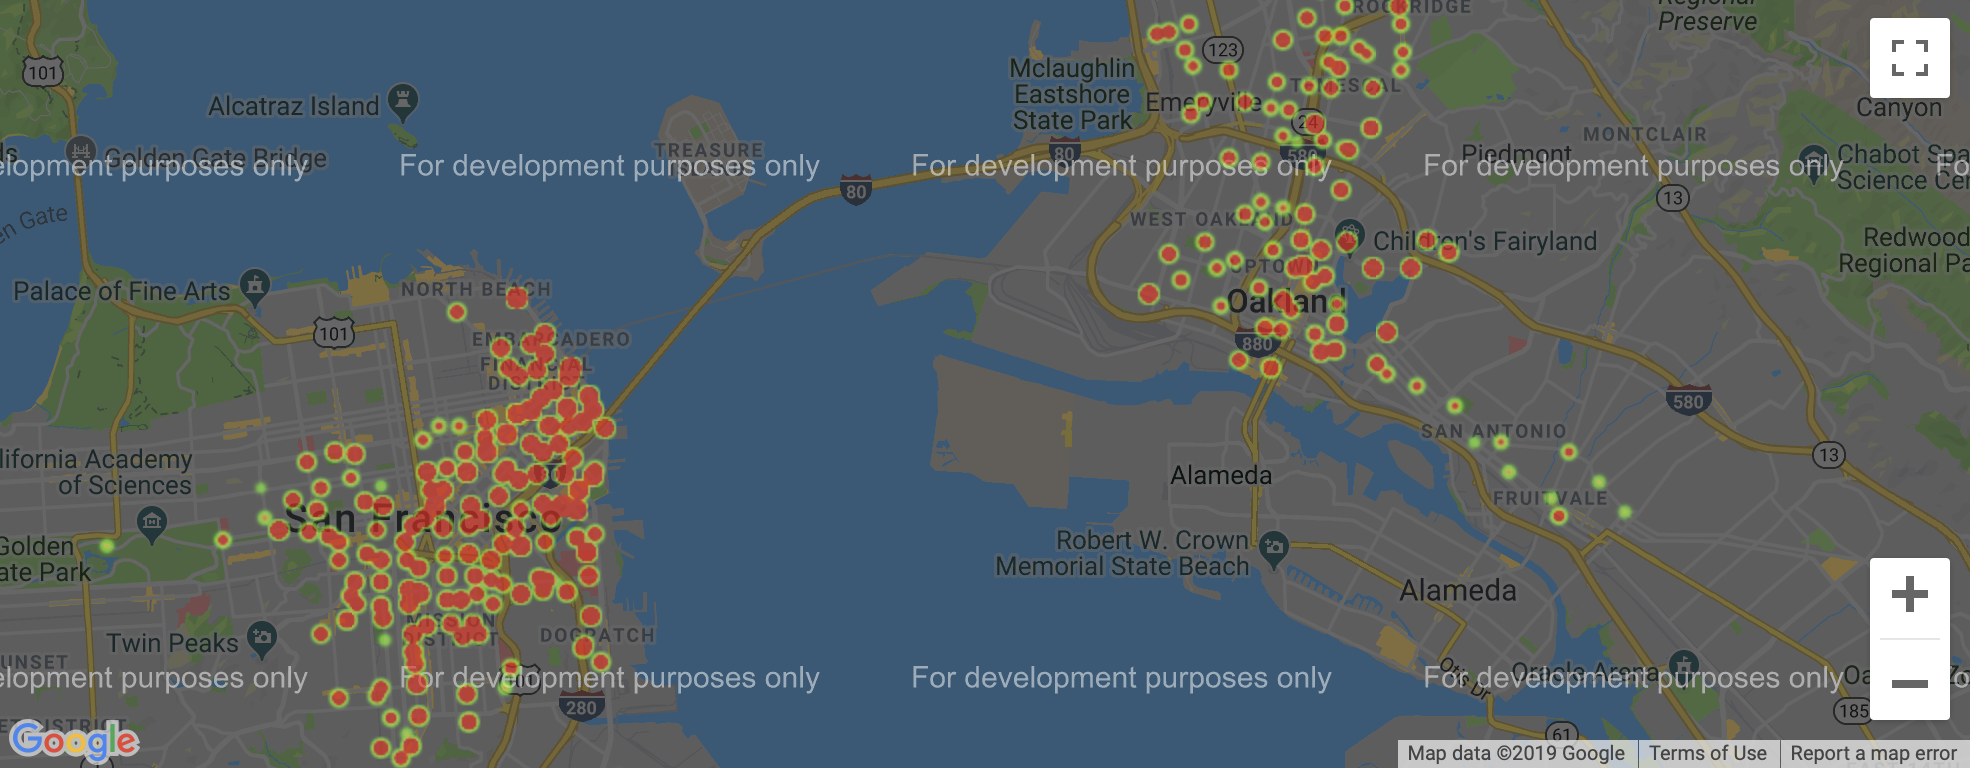

## 9. Breakdown of Clientele Gender

### Majority of the clientele is Male, followed by Female

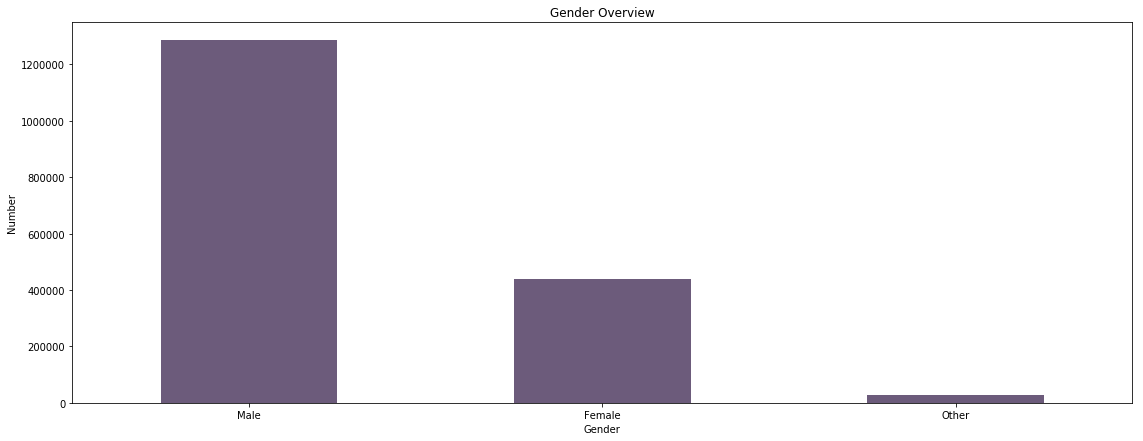

In [14]:
# Replace garbage values with something meaningful- Some more cleaning done
df['member_gender'] = df['member_gender'].str.replace('member_gender','Unknown')
df_gender = df['member_gender'].dropna()

# Get categories and their frequencies
df_gender = df_gender.value_counts().sort_values(ascending=False)

plt.figure(figsize=(19,7), facecolor='white')
plt.title("Gender Overview")
plt.ylabel('Number')
plt.xlabel('Gender')
ax = df_gender.plot.bar(x='lab', y='val', rot=0, color=mycolors)
plt.show()



## 10. Age Breakdown


#### Most bike riders in this ecosystem seem to be young working professionals as seen by the below age breakdown and above location charts. (Median age = 34).

#### The barplot shows that the distribution of age is right-skewed indicating a young population.

#### There are a few outliers according to the boxplot. Some of the senior San Franciscans have driven Ford GoBikes. However, there is some invalid data maybe due to human negligence as exhibited by age=134 in the boxplot.

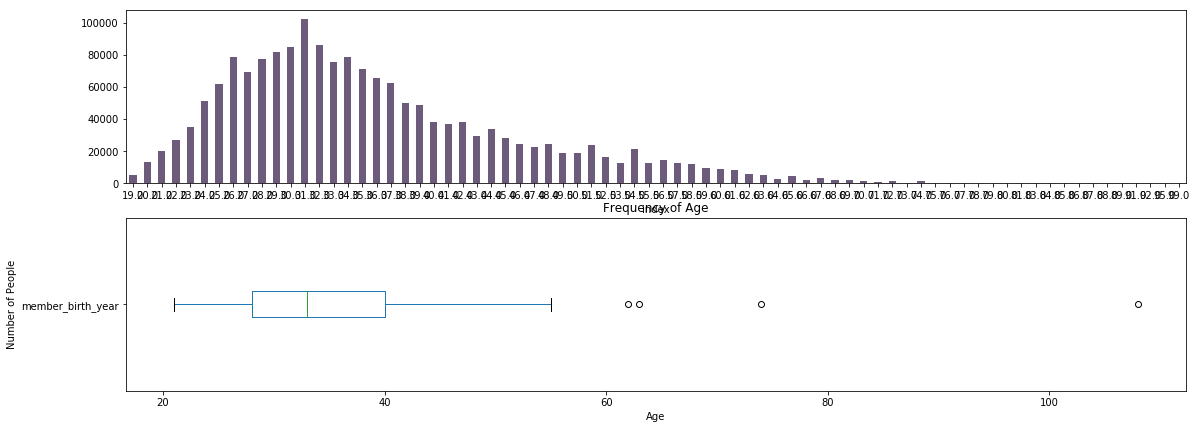

In [15]:
import numpy as np
import datetime
# Calculate member ages- certain ages are NaN and hence dropped
now = datetime.datetime.now()
df_clean_age = df[df['member_birth_year'] != 'member_birth_year']['member_birth_year']
df_clean_age = df_clean_age.dropna()
ser_age = float(now.year) - df_clean_age.astype('float64')
ser_age_box = ser_age.astype('float64')[ser_age.index<100]

# Create bins for a histogram
# bins = np.linspace(start=ser_age.min(), stop=ser_age.max(), num=13)
# ser_age = pd.cut(ser_age, bins)
ser_age_bar = ser_age.value_counts().sort_index(ascending=True)
ser_age_bar = ser_age_bar[ser_age_bar.index<100].to_frame().reset_index()
# Generate plot
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(19,7), facecolor='white')
plt.title("Frequency of Age")
plt.ylabel('Number of People')
plt.xlabel('Age')
ser_age_box.plot.box(vert=False, ax=ax[1])
ser_age_bar.plot.bar(y='member_birth_year', x='index', rot=0, color=mycolors, ax=ax[0], legend=False)
plt.show()

## 11. Quantifying the Impact of the Weather on Citi Bike Activity

#### From the plot, we can see that when the precipitation value is larger than 1.0, it rarely has bike trips  longer than 20,000 seconds or 5 hours. It shows that the heavier the rain is, the shorter is the trip duration.

#### Some of the trips have duration spanning more than 1 day. This could happen due to in-app errors or users simply forgetting to finish the trips in their apps thereby leading to a longer duration. Bike rides spanning more than 1 day do not sound feasible.

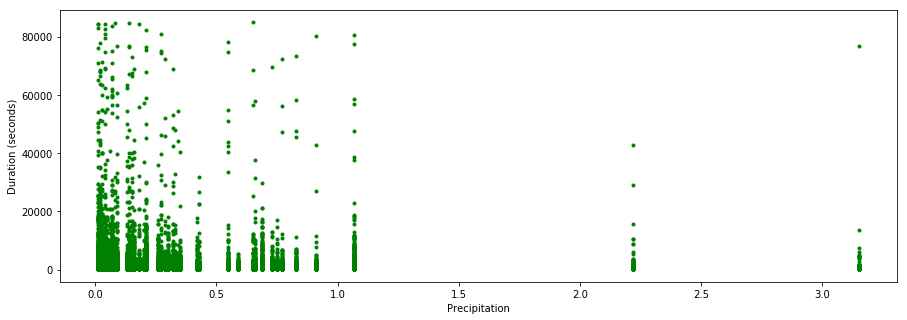

In [16]:
#Transform the types of "precipitation" and "duration_sec" to float
df['Precipitation'] = df['Precipitation'].astype('float64')
df['duration_sec'] = df['duration_sec'].astype('float64')
#Extract the dataframe which contains the rainy data
df_rainy = df[df['Precipitation']>0]
#Plot the Rain vs duration of bike rides
plt.figure(figsize=(15,5), facecolor='white')
plt.plot(df_rainy['Precipitation'],df_rainy['duration_sec'],'g.')
plt.xlabel('Precipitation')
plt.ylabel('Duration (seconds)')
plt.show()

## 12. Rain vs number of bike rides

#### From the plot, we can see the number of bike rides decreases as the precipitation value gets larger. As a result, we have the evidence to conclude that the rainy weather has a negative effect on the number of bike rides.

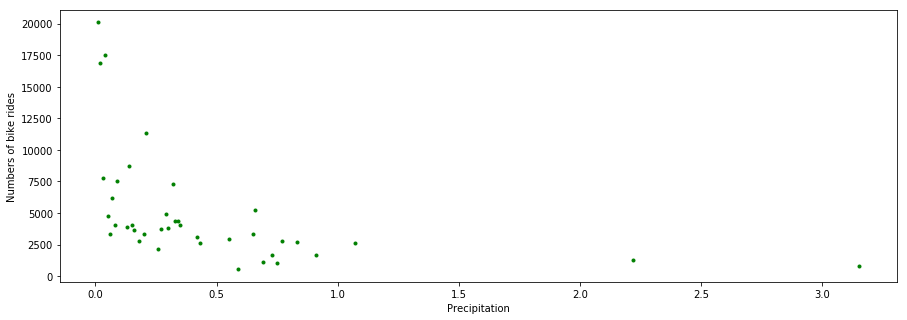

In [17]:
#Rain vs number of bike rides
num_ride_rainy=df_rainy['Precipitation'].value_counts()
num_ride_rainy
df2 = num_ride_rainy.to_frame()
column = df2.columns[0]
df2['index'] = df2.index.tolist()
plt.figure(figsize=(15,5), facecolor='white')
plt.plot(df2['index'],df2['Precipitation'],'g.')
plt.xlabel('Precipitation')
plt.ylabel('Numbers of bike rides')
plt.show()

In [18]:
#Using group by function to generate two coloums of  maximum temperature and start_date under same maximum teperature
#Group by again and calculate the mean usage of the different dates under same maximum temperature
df3=df[['start_date','Maximum']].groupby(["Maximum", "start_date"]).size().reset_index(name="usage").groupby(by='Maximum')['usage'].agg('mean').sort_values(ascending=False)
df3.sort_index().head()

Maximum
51    2727.50
52    3353.75
53    2141.00
54    2786.00
55    3947.25
Name: usage, dtype: float64

## 13. Maximum teperature VS average daily usage of bike rides

#### This graph makes shows there is a nonlinear relationship between rides and max daily temperature. The number of trips ramps up quickly between 55 and 65 degrees and above 80 degrees, but between 65 degrees and 80 degrees there’s a much weaker relationship between ridership and temperature. In general, it’s not surprising that the warmer the temperature is, the higher the number of average number of bike rides.

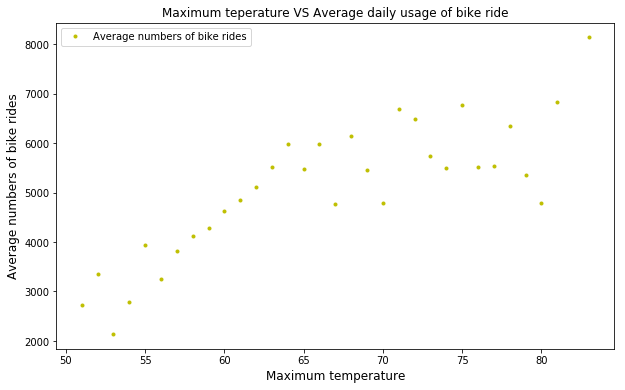

In [19]:
#Generate the plot of Maximum teperature VS Average daily usage of bike rides
fig = plt.figure(figsize=(10,6), facecolor='white')
plt.plot(df3,'y.',label='Average numbers of bike rides')
plt.title('Maximum teperature VS Average daily usage of bike ride')
plt.xlabel('Maximum temperature',fontsize=12)
plt.ylabel('Average numbers of bike rides',fontsize=12)
plt.legend()
plt.show()

## 14. Low income bike plan (bike_share_for_all_trip)

## 14.1 Gender vs bike_share_for_all_trip
#### <u>**bike_share_for_all_trip**</u>- This payment plan is for low income customers who want cheaper rides (they must qualify to get this!)

#### Although the number of male users is much higher than that of females, the proportion of males availing the low income plan is almost the same as that of females. 

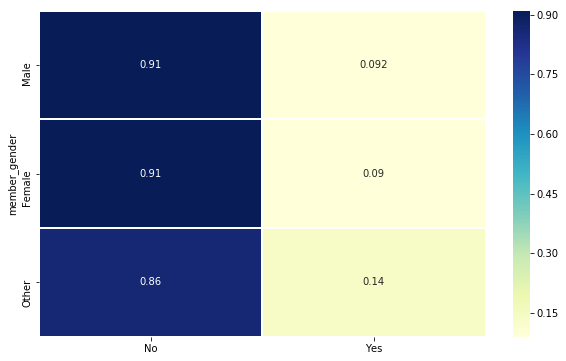

In [20]:
fig = plt.figure(figsize=(10,6), facecolor='white')
httable = pd.crosstab(index=df.member_gender, columns=df.bike_share_for_all_trip,normalize='index').loc[['Male','Female','Other']]
sns.heatmap(httable, cmap='YlGnBu', annot=True, square=False, linewidths=1)
plt.xlabel('');

## 14.2 User type (Subscriber vs Customer) vs bike_share_for_all_trip

#### In the plot below, we can see that more subscribers avail the low income payment plan than casual customers. The latter do not avail the plan since they use bikes relatively infrequently and are prepared to pay full price per ride

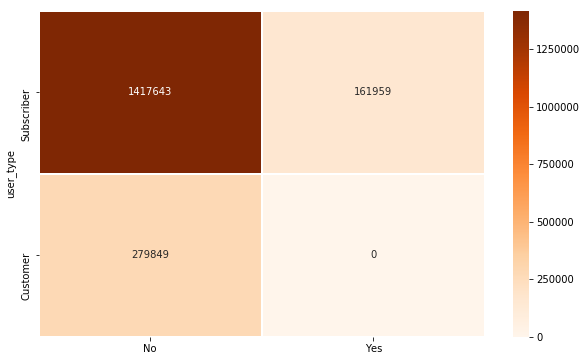

In [51]:
fig = plt.figure(figsize=(10,6), facecolor='white')
httable = pd.crosstab(index=df.user_type, columns=df.bike_share_for_all_trip).loc[['Subscriber','Customer']]
sns.heatmap(httable, cmap='Oranges', annot=True, fmt='d', square=False, linewidths=1)
plt.xlabel('');

## 15. User type; gender distribution

#### 90% of males are subscribers, and 85% of females are subscribers. A higher proportion of women are casual bikers.

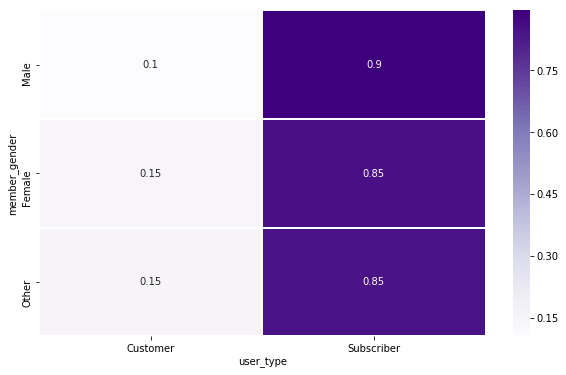

In [52]:
fig = plt.figure(figsize=(10,6), facecolor='white')
httable = pd.crosstab(index=df.member_gender, columns=df.user_type,normalize='index').loc[['Male','Female','Other']]
sns.heatmap(httable, cmap='Purples', annot=True, square=False, linewidths=1)


## 16. Prediction- Weather's effect on number of bike rides

### 16.1 Function to draw Predicted vs Actual values

In [26]:
def draw_pred_plot(y):
    fig = plt.figure(figsize=(12,8), facecolor='white')
    plt.plot(y_test, color = 'red', label = 'Real data')
    plt.plot(y, color = 'blue', label = 'Predicted data')
    plt.title('Prediction')
    plt.legend()
    plt.show()

### 16.2 Intermediate data structure

In [22]:
df0 = df[['Average', 'Departure', 'HDD', 'CDD','Precipitation','start_date']]
df0=df0.groupby('start_date').mean()

df1=df[['Average', 'Departure', 'HDD', 'CDD','Precipitation','start_date']]
df1 = df1.groupby('start_date').count()['Average']
df0['count']=df1
df0.head()

Average  Departure  HDD  CDD  Precipitation  count
start_date                                                    
2018-01-01     54.5        3.9   10    0           0.00   1375
2018-01-02     56.5        5.9    8    0           0.00   3252
2018-01-03     55.5        4.9    9    0           0.09   2857
2018-01-04     58.0        7.4    7    0           0.06   3300
2018-01-05     56.5        5.9    8    0           0.26   2150

### 16.3 Split data into training and test

In [23]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import mean_squared_error 
np.random.seed(12345)
dfr = df0[['Average', 'Departure', 'HDD', 'CDD','Precipitation']]
X_train, X_test, y_train, y_test = train_test_split(dfr, df0['count'].values, test_size=0.2)

### 16.4 Linear Regression

#### According to the below coefficients, all else being constant, the number of bike rides increases by 332 when the average temperature increases by 1F. Similarly, when there is a unit increase in precipitation, all else remaining equal, the number of bike rides decreases by 1543.

In [24]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
print('The out-of-sample R2 is', lr.score(X_test, y_test))
pd.DataFrame({'Feature': dfr.columns, 'Coefficient': lr.coef_}, columns=['Feature','Coefficient'])

The out-of-sample R2 is 0.45172667645381037


Feature  Coefficient
0        Average   332.409729
1      Departure  -220.542935
2            HDD    22.377685
3            CDD  -213.110904
4  Precipitation -1543.048483

### 16.5 Prediction using Linear Regression

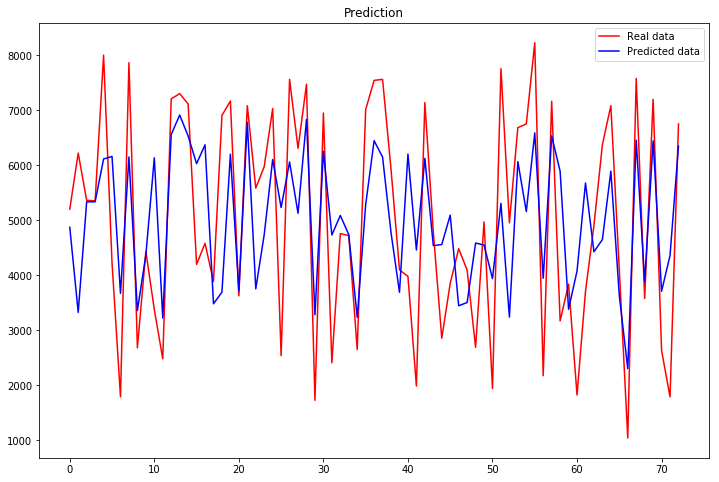

R^2:  0.45172667645381037
MSE Linear Regression:  2193254.2145143584


In [27]:
y = lr.predict(X_test)
draw_pred_plot(y)
r2lr = lr.score(X_test, y_test)
mselr =  mean_squared_error(y, y_test)
print("R^2: ", r2lr)
print("MSE Linear Regression: ", mselr)

## 17. Regression Tree

### 17.1 Get best estimator

#### This model has a greater Mean Squared Error (MSE) as compared to Linear Regression and does not predict unseen data as well as the latter.

The out-of-sample R2 is -0.11476123595160104


C:\Users\pujar\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



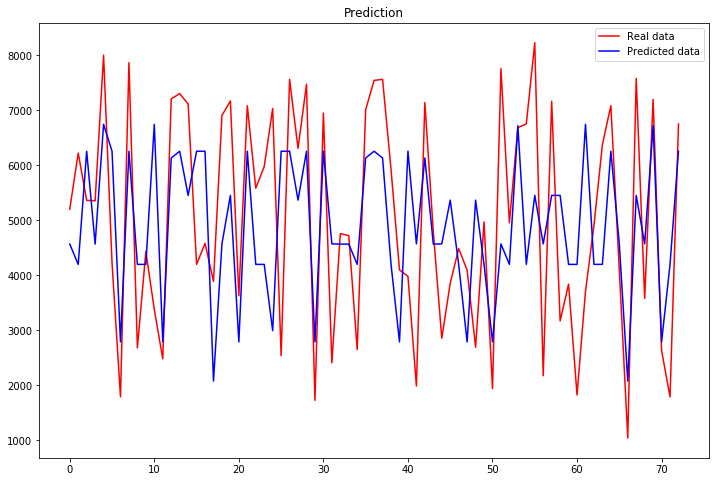

Tree R^2:  0.27211782716455146
MSE Tree:  2911742.3275595936


In [28]:
from sklearn import tree
# Fit the initial tree
tr = tree.DecisionTreeRegressor()
tr.fit(X_train, y_train)
r2tr = tr.score(X_test, y_test)
print('The out-of-sample R2 is', r2tr)
params = {'min_samples_split': [5,10,25,50], 'max_depth': [5,10,25]}
tree_grid = GridSearchCV(estimator=tr, param_grid=params, scoring='r2', cv=5, n_jobs=4)
tree_grid.fit(X_train, y_train)
# Assign best estimator to variable and evaluate performance
tree = tree_grid.best_estimator_
y = tree.predict(X_test)
draw_pred_plot(y)
r2tr = tree.score(X_test, y_test)
msetr = mean_squared_error(y, y_test)
print("Tree R^2: ",r2tr)
print("MSE Tree: ", msetr)


## 17.2 Visualize the tree to see rules

#### Each leaf node represents the number of trips this model would predict. Each decision node represents a business rule. Even though the predictive power of this model is not as good as Linear Regression, we can use the below image to visualize some of the rules for a better understanding of the biking phenomenon at a general level.

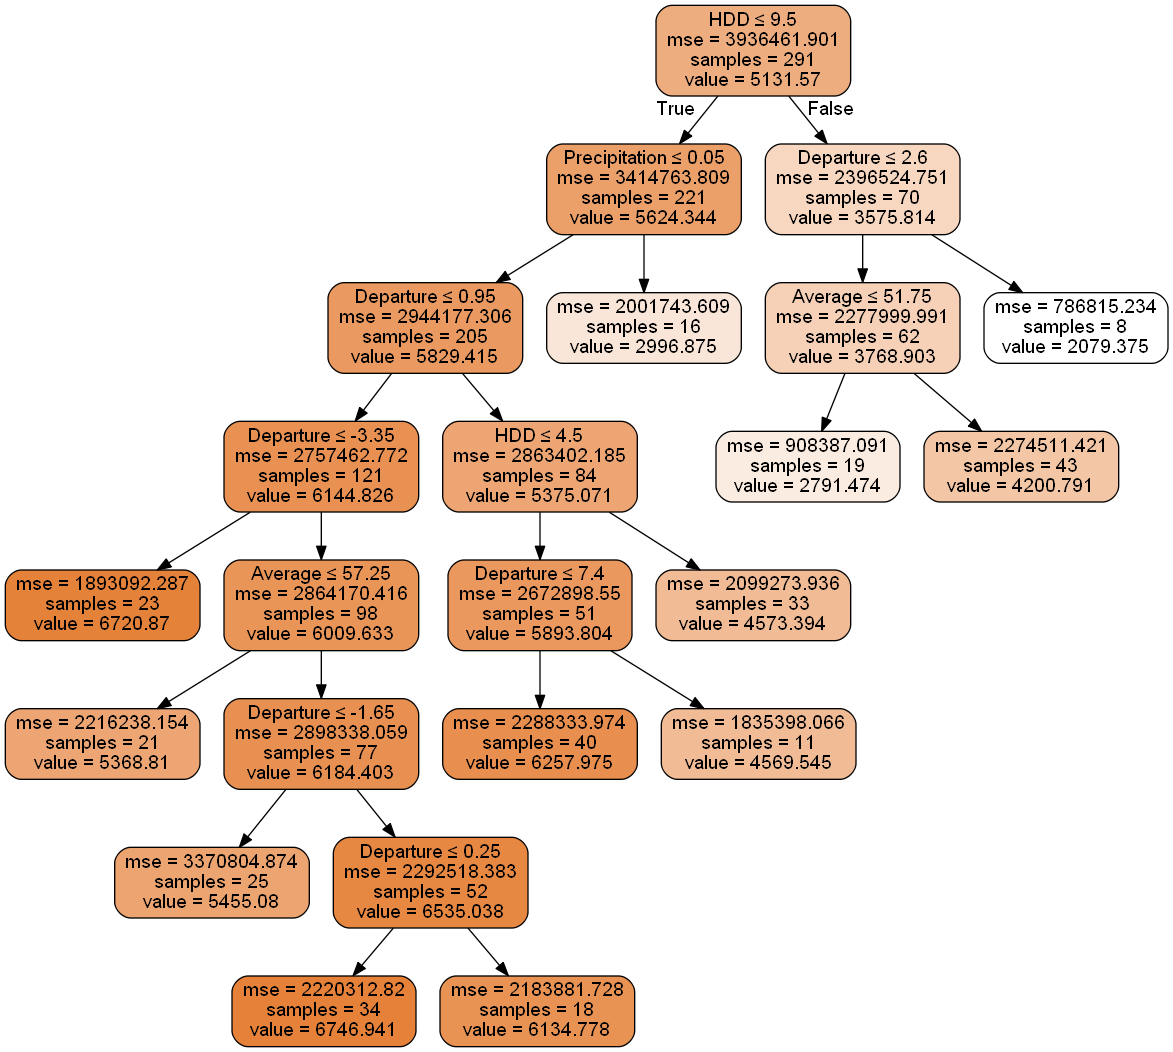

In [30]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, filled=True, rounded=True,special_characters=True, feature_names = X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Biking.png')
Image(graph.create_png())

## 18 Ensemble Methods- Boosting

### NOTE: Boost the Tree above

### 18.1 Set up boosting with tree

<Figure size 432x288 with 0 Axes>

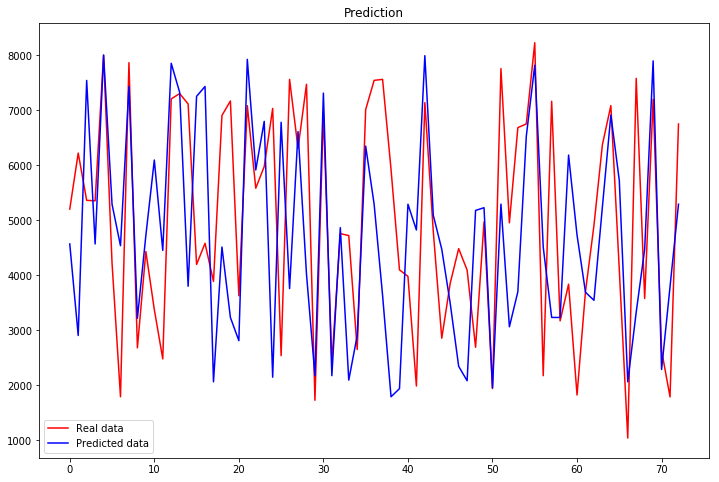

Boosting R^2:  0.3470633346266242
MSE Boosting: 4459372.130517504


In [31]:
from sklearn import ensemble as en
from sklearn import metrics

dt5 = en.AdaBoostRegressor(random_state=1, base_estimator=tree)
regr =dt5.fit(X_train, y_train) 
fig=plt.figure()

y = tr.predict(X_test)
draw_pred_plot(y)

r2b = regr.score(X_test, y_test)
mseb = mean_squared_error(y, y_test)
print("Boosting R^2: ", r2b)
y = regr.predict(X_test)
print("MSE Boosting:", mseb)

### 18.2 Most important variables

#### According to the boosted tree, Average temperature, Departure and Precipitation are the most important predictors in predicting number of bike rides.

In [32]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.graph_objs import *
import plotly.graph_objs as go
init_notebook_mode()
data = [go.Bar(
            x=X_test.columns.tolist(),
            y=regr.feature_importances_.tolist()
    )]

iplot(data)

## 19 Neural Networks

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


### 19.1 Feature Scaling

In [38]:
#Applying Min-Max Feature scaling
from sklearn.preprocessing import MinMaxScaler
min_max_sc = MinMaxScaler()
X_train1 = min_max_sc.fit_transform(X_train)
X_test1 = min_max_sc.transform(X_test)
y_train1=(y_train-y_train.min())/(y_train.max()-y_train.min())

### 19.2 Set up neural networks

In [39]:
np.random.seed(12345)
nn = Sequential()
nn.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu', input_dim = dfr.shape[1]))
nn.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'relu'))
nn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
nn.fit(X_train1, y_train1, batch_size = 10, epochs = 100)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
291/291 [==============================] - 0s 933us/step - loss: 0.4019 - acc: 0.0034
Epoch 2/100
291/291 [==============================] - 0s 79us/step - loss: 0.3486 - acc: 0.0034
Epoch 3/100
291/291 [==============================] - 0s 75us/step - loss: 0.2758 - acc: 0.0034
Epoch 4/100
291/291 [==============================] - 0s 75us/step - loss: 0.1979 - acc: 0.0034
Epoch 5/100
291/291 [==============================] - 0s 82us/step - loss: 0.1336 - acc: 0.0034
Epoch 6/100
291/291 [==============================] - 0s 82us/step - loss: 0.0940 - acc: 0.0034
Epoch 7/100
291/291 [==============================] - 0s 72us/step - loss: 0.0761 - acc: 0.0069
Epoch 8/100
291/291 [==============================] - 0s 79us/step - loss: 0.0704 - acc: 0.0034
Epoch 9/100
291/291 [==============================] - 0s 75us/step - loss: 0.0685 - acc: 0.0034
Epoch 

### 19.3 Export neural networks diagram

In [42]:
from ann_visualizer.visualize import ann_viz
ann_viz(nn, view=True, filename="neuralnetwork",  title="Neural Network")

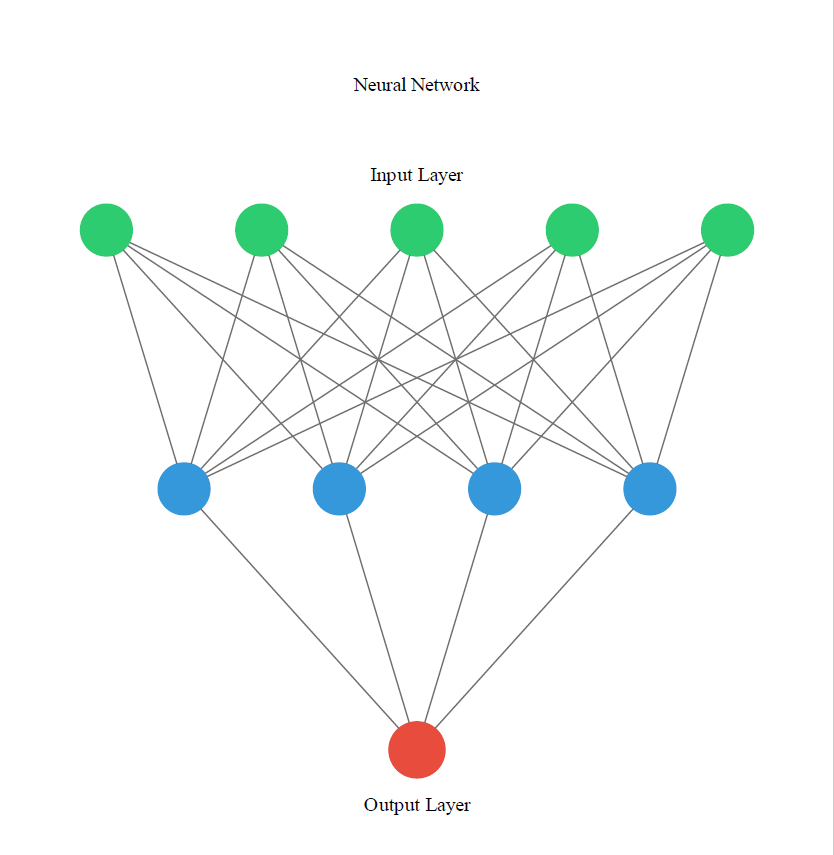

### 19.4 Prediction using neural networks

<Figure size 432x288 with 0 Axes>

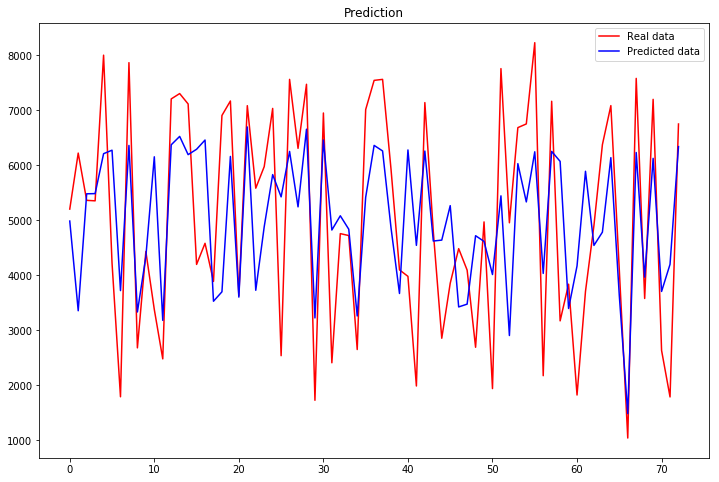

MSE Neural Network: 2284929.771157191


In [43]:
y_pred = nn.predict(X_test1)
y_pred1= y_pred*(y_train.max()-y_train.min())+y_train.min()
fig=plt.figure()
fig = plt.figure(figsize=(12,8), facecolor='white')
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred1, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()
msenn = mean_squared_error(y_pred1, y_test)
print("MSE Neural Network:",msenn)

## 20 Summarizing the predictive models

### 20.1 Compare their R^2 Values

#### Linear regression has the highest R^2 value

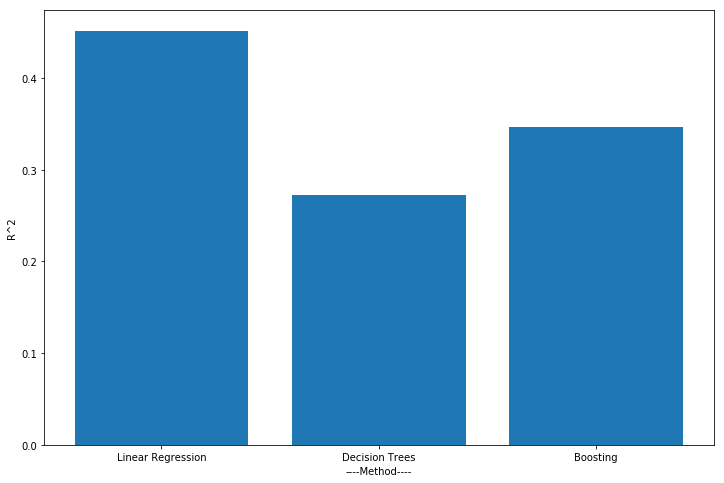

In [44]:
r2json = {"Linear Regression":r2lr, "Decision Trees":r2tr, "Boosting":r2b}
fig = plt.figure(figsize=(12,8), facecolor='white')
plt.bar(*zip(*r2json.items()))
plt.xlabel('----Method----')
plt.ylabel('R^2')
plt.show()

### 20.2 Compare their MSE values

#### Linear Regression has the lowest MSE value

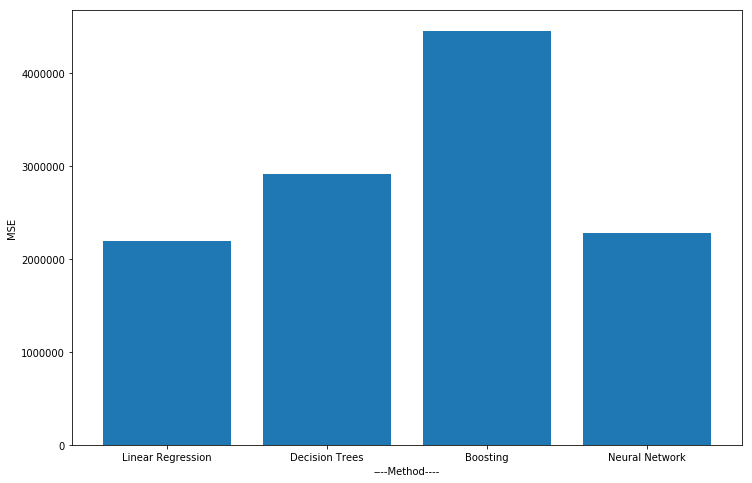

In [45]:
msejson = {"Linear Regression":mselr, "Decision Trees":msetr, "Boosting":mseb, "Neural Network":msenn}

fig = plt.figure(figsize=(12,8), facecolor='white')
plt.bar(*zip(*msejson.items()))
plt.xlabel('----Method----')
plt.ylabel('MSE')
plt.show()

## 21. Conclusion

Owing to the above results, it is clear that linear regression captures the relationship between independent and dependent variables best (out of the methods we compared). This leads us to believe that the relationship is more linear than non-linear.

The above predictive and explanatory models should help the management at Ford GoBikes plan their resources more effectively. Weather reports are typically released 7 days prior, and that should enable planners at the company to check where demand is highest. 

Biking is generally more environmentally friendly as compared to using fossil-fuel-powered vehicles, and would be a blessing to ease traffic congestion in the city (as shown in the Google maps plug in above). Also, it is a good way to relieve stress for both adults and children.

To cater to more people, Ford GoBike could expand their network further in areas such as West San Francisco where there are not many trips originating/ending. The presence of parks such as The Golden Gate Park and Sunset Reservoir park in West San Francisco would be good locations to deploy bikes.

Furthermore, they can create incentive programs for seniors, children and women to take up more biking as is evident from skewed demographic profiles observed above. As they plan on expanding further, they will find our predictive models useful in determining how many rides to expect. 